In [1]:
!pip install pytorch-ignite

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
# 以下、PyTorch-Igniteからのインポート
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers


In [3]:
DATA_DIR='./data' # データ保存用のディレクトリ
IMAGE_SIZE = 32 # 入力画像1辺のサイズ
NUM_CLASSES = 10 # 分類先のクラス数
NUM_WORKERS = 20 # データローダーが使用するサブプロセスの数を指定
BATCH_SIZE = 32 # ミニバッチのサイズ
LEARNING_RATE = 1e-3 # 学習率
WEIGHT_DECAY = 1e-1 # オプティマイザーの重み減衰率
EPOCHS = 100 # 学習回数


In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)


device: cuda


In [5]:
# トレーニングデータに適用する一連の変換操作を
# transforms.Compose(コンテナ)にまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右反転
    # 4ピクセルのパディングを挿入してランダムに切り抜く
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    # 画像の明るさ、コントラスト、彩度、色相をランダムに変化させる
    transforms.ColorJitter(
        brightness=0.2, # コントラストを0.8倍から1.2倍の範囲で変更
        contrast=0.2, # 彩度を0.8倍から1.2倍の範囲で変更
        saturation=0.2 # 色相を0.8倍から1.2倍の範囲で変更
    ),
    transforms.ToTensor() # テンソルに変換
])


In [6]:
# CIFAR-10データセットのトレーニングデータを読み込み、データ拡張を適用
train_dset = datasets.CIFAR10(
    root=DATA_DIR, train=True, download=True, transform=train_transform)
# CIFAR-10データセットのテストデータを読み込んでテンソルに変換する処理のみを行う
test_dset = datasets.CIFAR10(
    root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 170498071/170498071 [00:13<00:00, 12182883.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# トレーニング用のデータローダーを作成
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=BATCH_SIZE, # トレーニングデータとバッチサイズを設定
    shuffle=True, # 抽出時にシャッフルする
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True) # GPUを使用する場合、データを固定メモリにロードする
# テスト用のデータローダーを作成
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=BATCH_SIZE, # テストデータとバッチサイズを設定
    shuffle=False, # 抽出時にシャッフルしない
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True) # GPUを使用する場合、データを固定メモリにロードする


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
def init_linear(m):
    """ レイヤーの重みとバイアスを初期化する

    Args:
        m (nn.Module): 畳み込み層または全結合層のPyTorchモジュール
    """
    # モジュールが畳み込み層（nn.Conv2d）または全結合層（nn.Linear）であるかチェックする
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        # 重みをKaiming正規分布で初期化する
        nn.init.kaiming_normal_(m.weight)
        # バイアスが存在する場合、バイアスをゼロで初期化する
        if m.bias is not None:
            nn.init.zeros_(m.bias)


In [9]:
class Residual(nn.Module):
    """ 残差接続を行うネットワークを定義

    Attributes:
        residual:
            受け取ったレイヤーをnn.Sequentialで連結したシーケンシャルモデル
        gamma:
            学習可能なパラメーター
    """
    def __init__(self, *layers, shortcut=None):
        """ コンストラクター
        Args:
            *layers: レイヤーのシーケンス
            shortcut: ショートカット経路
        """
        super().__init__()
        # shortcutがNoneの場合、ショートカット経路self.shortにnn.Identityを設定
        # nn.Identityは入力をそのまま出力するモジュール
        self.shortcut = nn.Identity() if shortcut is None else shortcut
        # 受け取ったレイヤーをnn.Sequentialで連結する
        self.residual = nn.Sequential(*layers)
        # 学習可能な初期値ゼロのパラメータを1個作成
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """フォワードパス

        xに残差接続を適用する
        residualの最終レイヤーの出力にスケーリング係数gammaを掛けたものを
        ショートカット経路の出力に加える

        Args:
            x: 入力するテンソル
        """
        return self.shortcut(x) + self.gamma * self.residual(x)


In [10]:
class TakeFirst(nn.Module):
    """ TransformerBackboneからの出力テンソルから
        クラス識別トークンを抽出する

    """
    def forward(self, x):
        """ フォワードパス

        Args:
            x: 入力テンソル(bs, クラス識別トークン+トークン数, 埋め込み次元数)
                           (bs, 257, 256)

        Returns:
            xの第2次元の先頭要素(クラス識別トークン)を抽出して返す
            形状; (bs, 256)
        """
        return x[:, 0]


In [11]:
class SelfAttention(nn.Module):
    """ 自己注意機構(Multi-Head Self-Attention)を実装するネットワーク

    Attributes:
        head_shape (tuple): ヘッドの形状(heads, head_dim)
        scale (float): スケーリング係数
        to_keys (nn.Linear): キーを計算する全結合層
        to_queries (nn.Linear): クエリを計算する全結合層
        to_values (nn.Linear): バリューを計算する全結合層
        unifyheads (nn.Linear): ヘッドを統合する全結合層
        drop (nn.Dropout): ドロップアウトレイヤー
    """
    def __init__(self, dim, head_dim, heads=8, p_drop=0.):
        """ コンストラクター

        Args:
            dim (int): 埋め込み次元数(dim=64,またはdim=256)
            head_dim (int): ヘッドの次元数(head_dim=64)
            heads (int): ヘッドの数(heads=1,またはheads=4)
            p_drop (float): ドロップアウト率(0.3)
        """
        super().__init__()
        # head_dim(64)とheads(1または4)を掛けて入力の次元数を計算
        inner_dim = head_dim * heads
        # ヘッドの形状(1または4, 64)を保持
        self.head_shape = (heads, head_dim)
        # スケーリング係数を計算
        self.scale = head_dim**-0.5

        # キーを生成する全結合層（ユニット数: head_dim * heads)
        self.to_keys = nn.Linear(dim, inner_dim)
        # クエリを計算する全結合層（ユニット数: head_dim * heads)
        self.to_queries = nn.Linear(dim, inner_dim)
        # クエリを計算する全結合層（ユニット数: head_dim * heads)
        self.to_values = nn.Linear(dim, inner_dim)
        # ヘッドを統合する全結合層
        # 入力次元数: head_dim * heads
        # ユニット数: dim=64,またはdim=256
        self.unifyheads = nn.Linear(inner_dim, dim)
        # ドロップアウトレイヤーを初期化
        self.drop = nn.Dropout(p_drop)

    def forward(self, x):
        """ フォワードパス

        Args:
            x: 入力テンソル(bs, トークン数, 埋め込み次元数)
        Returns:
            out: Multi-Head Self-Attention適用後のテンソル
                形状: (bs, トークン数, dim)
                - dim: コンテキストベクトルの次元数
        """
        # 入力テンソルの形状x.shape[:-1]で埋め込み次元を除いた形状に
        # ヘッドの形状(heads, head_dim)を追加して
        # (bs, トークン数, heads, head_dim)の形状を作る
        q_shape = x.shape[:-1] + self.head_shape

        # キーを作成
        # 入力テンソルxをto_keysレイヤーに入力し、埋め込み次元数を
        # 「head_dim * heads」に拡張した後、形状を
        # (bs, トークン数, heads, head_dim)に変換
        # 第2次元と第3次元を入れ換えて
        # (bs, heads, トークン数, head_dim)にする
        keys = self.to_keys(x).view(q_shape).transpose(1, 2)
        # クエリを作成(キー作成と同じ処理)
        # (bs,  heads, トークン数, head_dim)
        queries = self.to_queries(x).view(q_shape).transpose(1, 2)
        # バリューを作成(キー作成と同じ処理)
        # (bs,  heads, トークン数, head_dim)
        values = self.to_values(x).view(q_shape).transpose(1, 2)

        # クエリとキー(トークン数とhead_dimの次元を転置)のドット積を計算して
        # アテンションスコアを得る
        att = queries @ keys.transpose(-2, -1)

        # アテンションスコアをスケーリングしてソフトマックス関数で正規化し、
        # アテンション重みを得る
        att = F.softmax(att * self.scale, dim=-1)
        # アテンション重みとバリューのドット積を計算して出力を得る
        # outの形状:(bs, heads, トークン数, head_dim)
        out = att @ values

        # outの第2次元と第3次元を入れ換え(bs,トークン数, heads, head_dim)
        # contiguous()適用後、第3次元以降をフラット化
        # outの形状:(bs, トークン数, heads * head_dim)
        out = out.transpose(1, 2).contiguous().flatten(2)

        # ヘッドを統合する
        # unifyheadsレイヤーでheads * head_dimの次元を
        # dim(dim=64,またはdim=256)に線形変換
        # outの形状:(bs, トークン数, dim)
        out = self.unifyheads(out)

        out = self.drop(out) # ドロップアウトを適用

        return out


In [12]:
class FeedForward(nn.Sequential):
    """ フィードフォワードニューラルネットワーク（MLP）を定義

    """
    def __init__(self, dim, mlp_mult=4, p_drop=0.):
        """ コンストラクター

            Args:
                dim (int): 埋め込み次元数(dim=64,またはdim=256)
                mlp_mult (int): 中間層の次元数を決定する倍率(1または4)
                p_drop (float): ドロップアウト率(0.3)
        """
        # 隠れ層の次元数を決定
        hidden_dim = dim * mlp_mult

        # スーパークラスのコンストラクターを実行
        super().__init__(
            # 隠れ層(ユニット数:dim * mlp_mult)
            nn.Linear(dim, hidden_dim),
            nn.GELU(), # 非線形活性化関数GELUを適用
            # 出力層(ユニット数:dim)
            nn.Linear(hidden_dim, dim),
            # ドロップアウトを適用
            nn.Dropout(p_drop)
        )


In [13]:
class TransformerBlock(nn.Sequential):
    """ Transformerブロックを定義

    """
    def __init__(self, dim, head_dim, heads, mlp_mult=4, p_drop=0.):
        """ コンストラクター
            Args:
        Args:
            dim (int): 埋め込み次元数(dim=64,またはdim=256)
            head_dim (int): ヘッドの次元数(head_dim=64)
            heads (int): ヘッドの数(heads=1,またはheads=4)
            mlp_mult (int): 隠れ層の次元数を決定する倍率(1または4)
            p_drop (float): ドロップアウト率(0.3)
        """
        # スーパークラスのコンストラクターを実行
        super().__init__(
            # 残差接続付きSelfAttentionネットワークを構築
            Residual(
                nn.LayerNorm(dim), # 正規化レイヤー
                SelfAttention(dim, head_dim, heads, p_drop) # SelfAttention
            ),
            # 残差接続付きフィードフォワードネットワークを構築
            Residual(
                nn.LayerNorm(dim), # 正規化レイヤー
                FeedForward(dim, mlp_mult, p_drop=p_drop) # FeedForward
            )
        )


In [14]:
class SoftSplit(nn.Module):
    """ 入力テンソルをパッチに分割し、プロジェクションを適用して
        トークンに変換するネットワーク

    Attributes:
        unfold (nn.Unfold): 画像を小さなトークンに分割するためのモジュール
        project (nn.Linear): トークンごとにプロジェクションを行うための全結合層
    """
    def __init__(self, in_channels, dim, kernel_size=3, stride=2):
        """ コンストラクター

        Args:
            in_channels (int): 入力テンソルのチャンネル数(3)
            kernel_size (int): トークンのサイズを決定するカーネルサイズ(3)
            dim (int): 埋め込み次元数(64または256)
            stride (int): 分割する際のストライド(移動量)
                          stride=1,またはstride=2
        """
        super().__init__()
        # パディングを計算
        # 入力と出力の空間サイズを一致させるために使用
        padding = (kernel_size - 1) // 2
        # トークンに分割するモジュールを定義
        self.unfold = nn.Unfold(
            kernel_size, # 分割するトークンのサイズ(高さと幅)
            stride=stride, # 分割する際のストライド(移動量)
            padding=padding # パディングのサイズ
            )
        # プロジェクションレイヤーを定義
        # トークンのデータ次元数を埋め込み次元数dimに変換する全結合層
        self.project = nn.Linear(
            in_channels * kernel_size**2, # 入力の次元数
            dim # 埋め込み次元数
            )

    def forward(self, x):
        """ フォワードパス

        Args:
            x: 入力画像のテンソル(bs, チャンネル次元数, 高さ, 幅):(bs, 3, 32, 32)
               またはSelfAttentionによるコンテキスト計算後のテンソル
               (bs, トークン数, コンテキスト次元数):(32, 64, 32, 32)

        Returns:
            out: トークン分割とプロジェクションを適用した出力テンソル
            (bs, トークン数, 埋め込み次元数(64,または256))
            in:(bs, 3, 32, 32) --> out:(bs, 1024, 64)
            in:(bs, 64, 32, 32) --> out:(bs, 256, 256)
        """
        # 入力テンソルをパッチに分割し、次元を変換
        # unfold(x)適用後の形状:
        # (bs, kernel_size * kernel_size * in_channels, トークンの数)
        # transpose(1, 2)適用後の形状:
        # (bs, トークンの数, kernel_size * kernel_size * in_channels)
        out = self.unfold(x).transpose(1, 2)

        # プロジェクションレイヤーを適用し、トークンのデータ次元数を埋め込み次元数に変換
        # outの形状: (bs, トークン数, 埋め込み次元数)
        out = self.project(out)

        return out


In [15]:
class Reshape(nn.Module):
    """ 入力テンソルの形状を変更する処理を行うレイヤー

    Attributes:
        shape (tuple): 再構成する新しい形状
    """
    def __init__(self, shape):
        """ コンストラクター

        Args:
            shape (tuple): 再構成する新しい形状(例: (32, 32))
        """
        super().__init__()
        self.shape = shape # 新しい形状を保存

    def forward(self, x):
        """ フォワードパス

        Args:
            x: 入力テンソル(bs, トークン数, コンテキスト次元数)

        Returns:
            out: 形状が再構成されたテンソル
                 (bs, コンテキスト次元数, shape[0], shape[1])
        """
        # 入力x(bs, トークン数, コンテキスト次元数)の第2次元と第3次元次元を入れ換えて
        # トークン数の次元をshape(例: (32, 32))に展開する
        # outの形状: (bs, コンテキスト次元数, shape[0], shape[1])
        out = x.transpose(1, 2).unflatten(2, self.shape)

        return out


In [16]:
class T2TBlock(nn.Sequential):
    """ SoftSplitとTransformerBlockを組み合わせて
        段階的にトークンを変換するブロック

    """
    def __init__(self, image_size, token_dim, embed_dim,
                 heads=1, mlp_mult=1, stride=2, p_drop=0.):
        """
        コンストラクター

        Args:
            image_size (int): 入力画像のサイズ(32)
            token_dim (int): トークンの次元数(64)
            embed_dim (int): 埋め込み次元数(64,または256)
            heads (int): ヘッドの数(1)
            mlp_mult (int): MLPの次元数を決定する倍率(1)
            stride (int): パッチのストライド(1,または2)
            p_drop (float): ドロップアウト率(0.3)
        """
        # スーパークラス(nn.Sequential)のコンストラクターを呼び出す
        super().__init__(
            # 自己注意機構を適用するTransformerBlockを配置
            TransformerBlock(
                token_dim, # トークンの次元数(64)
                token_dim // heads, # ヘッドの次元数(64)
                heads, # ヘッドの数(1)
                mlp_mult, #  MLPの次元倍率(1)
                p_drop # ドロップアウト率(0.3)
            ),
            # 入力テンソル(bs, トークン数, コンテキスト次元数)の形状を
            # (bs, トークン次元数, image_size, image_size)に変更
            Reshape(
                (image_size, image_size)
            ),
            # 入力テンソルをトークンに分割し、プロジェクションを適用
            SoftSplit(
                token_dim, embed_dim, stride=stride
            )
        )


In [17]:
class T2TModule(nn.Sequential):
    """ T2TBlockを3段スタックしたネットワークを構築
        段階的にトークンを生成し、トークン間の関係を学習する
    """
    def __init__(self, in_channels, image_size,
                 strides, token_dim, embed_dim, p_drop=0.):
        """
        コンストラクター

        Args:
            in_channels (int): 入力画像のチャネル数(3)
            image_size (int): 入力画像のサイズ(32)
            strides (list): 各 `T2TBlock` のストライドのリスト[1, 1, 2]
            token_dim (int): トークンの次元数(64)
            embed_dim (int): 最終的な埋め込み次元数(256)
            p_drop (float): ドロップアウト率(0.3)
        """
        # 最初のストライド(1)を取得
        stride = strides[0]
        # 最初のSoftSplitネットワークを配置
        # 入力画像のテンソル(bs, チャンネル次元数, 高さ, 幅):(bs, 3, 32, 32)
        # トークン分割後: (bs, トークン数, 埋め込み次元数(64)):(bs, 1024, 64)
        layers = [SoftSplit(in_channels, token_dim, stride=stride)]

        # 画像サイズをストライドで割る
        image_size = image_size // stride

        # 残りのストライド(1と2)を処理するT2TBlockを2ブロック配置
        for stride in strides[1:-1]:
            # 各ストライドに対してT2TBlockを追加
            layers.append(
                T2TBlock(
                    image_size, # 32-->16
                    token_dim, # 64-->64
                    token_dim, # 64-->64
                    stride=stride, # 1-->2
                    p_drop=p_drop
                )
            )
            # 画像サイズをストライドで割る
            image_size = image_size // stride

        # 最後のストライドを取得
        stride = strides[-1]
        # 3番目のT2TBlockを配置
        layers.append(
            T2TBlock(
                image_size, # 32
                token_dim, # 64
                embed_dim, # 256
                stride=stride, # 2
                p_drop=p_drop
            )
        )

        # スーパークラス(nn.Sequential)のコンストラクターを呼び出し、レイヤーを渡す
        super().__init__(*layers)


In [18]:
class PositionEmbedding(nn.Module):
    """ 位置埋め込みとクラス識別トークンを追加する
        自己注意機構を適用後のテンソルに位置情報を埋め込み、
        クラス識別トークンをトークン次元の先頭に追加する

    Attributes:
        pos_embedding: 位置情報を学習するパラメーター
        cls_token: クラス識別トークンとしての学習可能なパラメーター
    """
    def __init__(self, image_size, dim):
        """
        コンストラクター

        Args:
            image_size (int): 入力画像のサイズ(16)
            dim (int): 埋め込み次元数(256)
        """
        super().__init__()
        # 位置情報を学習するパラメーターを初期化
        # 形状:(1, image_size**2, dim): (1, 256, 256)
        self.pos_embedding = nn.Parameter(torch.zeros(1, image_size**2, dim))
        # クラス識別トークンを初期化
        # 形状:(1, 1, dim): (1, 1, 256)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))

    def forward(self, x):
        """ フォワードパス

        Args:
            x: SelfAttentionによるコンテキスト計算後のテンソルに
               トークン分割とプロジェクションを適用した後のテンソル
               (bs,トークン数, 埋め込み次元数): (bs, 256, 256)

        Returns:
            x: 位置埋め込みとクラス識別トークンが追加された出力テンソル
        """
        # 入力テンソルに位置埋め込みを加算
        # x: (bs, 256, 256)
        x = x + self.pos_embedding
        # クラス識別トークンをバッチサイズに合わせて展開
        # cls_tokens: (bs, 1, 256)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        # クラス識別トークンを入力テンソルの先頭に連結
        # x: (bs, 257, 256)
        x = torch.cat((cls_tokens, x), dim=1)

        return x


In [19]:
class TransformerBackbone(nn.Sequential):
    """ 位置情報の埋め込みとクラス識別トークン追加後に
        複数のTransformerBlockを適用する

    """
    def __init__(self, dim, head_dim, heads, depth, mlp_mult=4, p_drop=0.):
        """ コンストラクター

        Args:
            dim (int): 入力テンソルの次元数(256)
            head_dim (int): 各ヘッドの次元数(64)
            heads (int): ヘッドの数(4)
            depth (int): TransformerBlockの数(8)
            mlp_mult (int): MLPの次元数を決定する倍率(4)
            p_drop (float): ドロップアウト率(0.3)
        """
        # 指定された数(8)のTransformerBlockを配置
        # 各TransformerBlockは、
        # 入力テンソル(bs, 257, 256)に対し、(bs, 257, 256)を出力
        layers = [
            TransformerBlock(
                dim, head_dim, heads, mlp_mult, p_drop) for _ in range(depth)
        ]

        # スーパークラス(nn.Sequential)のコンストラクターを呼び出し、レイヤーを渡す
        super().__init__(*layers)


In [20]:
class Head(nn.Sequential):
    """ T2T-ViTモデルの最終層、クラス分類を行う

    """
    def __init__(self, dim, classes, p_drop=0.):
        """ コンストラクター

        Args:
            dim (int): 埋め込み次元数(256)
            classes (int): 分類するクラスの数(10)
            p_drop (float): ドロップアウト率(0.3)
        """
        # スーパークラス(nn.Sequential)のコンストラクターを呼び出し、レイヤーを渡す
        super().__init__(
            nn.LayerNorm(dim), # 正規化レイヤー
            nn.Dropout(p_drop), # ドロップアウトを適用
            # ユニット数classesの全結合層で線形変換を適用して出力
            nn.Linear(dim, classes)
        )


In [21]:
class T2TViT(nn.Sequential):
    """ T2T-ViT(Tokens-to-Tokens Vision Transformer)モデル

    """
    def __init__(self, classes, image_size, strides, token_dim,
                 dim, head_dim, heads, backbone_depth, mlp_mult,
                 in_channels=3, trans_p_drop=0., head_p_drop=0.):
        """ コンストラクター

        Args:
            classes (int): 出力クラス数(10)
            image_size (int): 入力画像のサイズ(32)
            strides (list): 各 `T2TBlock` のストライドのリスト[1, 1, 2]
            token_dim (int): トークンの次元数(64)
            dim (int): 埋め込み次元数(256)
            head_dim (int): 各ヘッドの次元数(64)
            heads (int): ヘッドの数(4)
            backbone_depth (int): トランスフォーマーバックボーンの深さ(8)
            mlp_mult (int): MLPの次元数を決定する倍率
            in_channels (int): 入力画像のチャネル数(3)
            trans_p_drop (float): トランスフォーマーブロック内のドロップアウト率(0.3)
            head_p_drop (float): Headレイヤーのドロップアウト率(0.3)
        """
        # ストライドを適用した後の画像サイズを計算
        reduced_size = image_size // np.prod(strides)
        # スーパークラス(nn.Sequential)のコンストラクターを呼び出す
        super().__init__(
            # T2TModuleを配置
            T2TModule(
                in_channels,
                image_size, strides,
                token_dim,
                dim,
                p_drop=trans_p_drop
            ),
            # 位置情報の埋め込みとクラス識別トークンを追加
            PositionEmbedding(reduced_size, dim),
            # TransformerBackboneを配置
            TransformerBackbone(
                dim,
                head_dim,
                heads,
                backbone_depth,
                p_drop=trans_p_drop
            ),
            # クラス識別トークンを抽出
            TakeFirst(),
            # 最終レイヤーにクラス識別トークンを入力して
            # クラス分類を実施
            Head(
                dim,
                classes,
                p_drop=head_p_drop
            )
        )


In [22]:
model = T2TViT(
    NUM_CLASSES,       # クラスの数
    IMAGE_SIZE,        # 入力画像のサイズ
    strides=[1, 1, 2], # 各T2TBlockのストライドのリスト
    token_dim=64,      # トークンの次元数
    dim=256,           # 埋め込み次元数
    head_dim=64,       # ヘッドの次元数
    heads=4,           # ヘッドの数
    backbone_depth=8,  # TransformerBackboneにおけるTransformerBlockの数
    mlp_mult=2,        # MLPの次元数を決定する倍率
    trans_p_drop=0.3,  # TransformerBlockのドロップアウト率
    head_p_drop=0.3    # Headレイヤーのドロップアウト率
)


In [23]:
# モデルの全てのネットワークに対してinit_linear()関数を適用し、
# 重みとバイアスを初期化する
model.apply(init_linear);


In [24]:
from torchsummary import summary

# モデルを指定されたデバイス（DEVICE）に移動
model.to(DEVICE);
# モデルのサマリを表示
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Unfold-1             [-1, 27, 1024]               0
            Linear-2             [-1, 1024, 64]           1,792
         SoftSplit-3             [-1, 1024, 64]               0
          Identity-4             [-1, 1024, 64]               0
         LayerNorm-5             [-1, 1024, 64]             128
            Linear-6             [-1, 1024, 64]           4,160
            Linear-7             [-1, 1024, 64]           4,160
            Linear-8             [-1, 1024, 64]           4,160
            Linear-9             [-1, 1024, 64]           4,160
          Dropout-10             [-1, 1024, 64]               0
    SelfAttention-11             [-1, 1024, 64]               0
         Residual-12             [-1, 1024, 64]               0
         Identity-13             [-1, 1024, 64]               0
        LayerNorm-14             [-1, 1

In [25]:
def separate_parameters(model):
    """ モデルのパラメーターを重み減衰を適用するものと適用しないものに分離する

    Args:
        model (nn.Module): パラメータを分離する対象のPyTorchモデル
    """
    # 重み減衰を適用するパラメータのセット
    parameters_decay = set()
    # 重み減衰を適用しないパラメータのセット
    parameters_no_decay = set()
    # 重み減衰を適用するモジュールのタプル
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    # 重み減衰を適用しないモジュールのタプル
    modules_no_weight_decay = (nn.LayerNorm, PositionEmbedding)

    # モデル内のすべてのモジュールを名前と共に反復処理
    for m_name, m in model.named_modules():
        # 各モジュールのすべてのパラメータを名前と共に反復処理
        for param_name, param in m.named_parameters():
            # フルパラメーター名を作成
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name
            # モジュールが重み減衰を適用しないモジュールに含まれる場合
            if isinstance(m, modules_no_weight_decay):
                # パラメータを重み減衰を適用しないセットに追加
                parameters_no_decay.add(full_param_name)
            # パラメータ名が "bias" で終わる場合
            elif param_name.endswith("bias"):
                # パラメーターを重み減衰を適用しないセットに追加
                parameters_no_decay.add(full_param_name)
            # モジュールが Residual でパラメータ名が "gamma" で終わる場合
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                # パラメーターを重み減衰を適用しないセットに追加
                parameters_no_decay.add(full_param_name)
            # モジュールが重み減衰を適用するモジュールに含まれる場合
            elif isinstance(m, modules_weight_decay):
                # パラメーターを重み減衰を適用するセットに追加
                parameters_decay.add(full_param_name)

    # 重み減衰を適用するパラメーターと適用しないパラメータが重複していないことを確認
    assert len(parameters_decay & parameters_no_decay) == 0
    # すべてのパラメーターがいずれかのセットに含まれていることを確認
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    # 重み減衰を適用するパラメータと適用しないパラメータのセットを返す
    return parameters_decay, parameters_no_decay


In [26]:
def get_optimizer(model, learning_rate, weight_decay):
    """ モデルのパラメーターに基づいてオプティマイザーを取得する

    Args:
        model (nn.Module): 最適化するPyTorchモデル
        learning_rate (float): オプティマイザーの学習率
        weight_decay (float): 重み減衰の率

    Returns:
        optimizer (torch.optim.Optimizer): AdamWオプティマイザ
    """
    # モデルの全パラメータを名前と共に辞書に格納
    param_dict = {pn: p for pn, p in model.named_parameters()}
    # 重み減衰を適用するパラメーターと適用しないパラメーターに分離
    parameters_decay, parameters_no_decay = separate_parameters(model)
    # 最適化するパラメーターのグループを定義
    optim_groups = [
        # 重み減衰を適用するパラメーター
        {"params": [param_dict[pn] for pn in parameters_decay],
         "weight_decay": weight_decay},
         # 重み減衰を適用しないパラメーター
        {"params": [param_dict[pn] for pn in parameters_no_decay],
         "weight_decay": 0.0},
    ]

    # AdamWオプティマイザーを作成
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer # オプティマイザーを返す


In [27]:
# 損失関数としてクロスエントロピー損失を定義
loss = nn.CrossEntropyLoss()

# オプティマイザーを取得
optimizer = get_optimizer(
    model, # 学習対象のモデル
    learning_rate=1e-6, # 学習率
    weight_decay=WEIGHT_DECAY # 重み減衰（正則化）の係数
)

# 教師あり学習用トレーナーを定義
trainer = create_supervised_trainer(
    model, optimizer, loss, device=DEVICE
)

# 学習率スケジューラーを定義
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, # オプティマイザー
    max_lr=LEARNING_RATE, # 最大学習率
    steps_per_epoch=len(train_loader), # 1エポックあたりのステップ数
    epochs=EPOCHS # 総エポック数
)

# トレーナーにイベントハンドラーを追加
# トレーナーの各イテレーション終了時に学習率スケジューラーを更新
trainer.add_event_handler(
    Events.ITERATION_COMPLETED, # イテレーション終了時のイベント
    lambda engine: lr_scheduler.step() # 学習率スケジューラーのステップを進める
)

 # トレーナーにランニングアベレージメトリクスを追加
 # トレーニングの損失をランニング平均で保持
ignite.metrics.RunningAverage(
    output_transform=lambda x: x  # 出力をそのまま使用
    ).attach(trainer, "loss") # トレーナーに"loss"としてアタッチ

# 検証用のメトリクス(評価指標)を定義
val_metrics = {
    "accuracy": ignite.metrics.Accuracy(),  # 精度
    "loss": ignite.metrics.Loss(loss)  # 損失
}

# トレーニングデータ用の評価器を定義
train_evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（GPUを想定）
)

# バリデーションデータ用の評価器を定義
evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（CPUまたはGPU）
)

# トレーニング履歴を保持するための辞書を初期化
history = defaultdict(list)


In [28]:
# トレーナーがエポックを完了したときにこの関数を呼び出すためのデコレーター
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """ エポック完了時にトレーニングと検証の損失および精度を記録してログに出力

    Args:
        engine: トレーナーの状態を保持するエンジンオブジェクト
    """
    # トレーナーの状態を取得
    train_state = engine.state
    # 現在のエポック数を取得
    epoch = train_state.epoch
    # 最大エポック数を取得
    max_epochs = train_state.max_epochs
    # 現在のエポックのトレーニング損失を取得
    train_loss = train_state.metrics["loss"]
    # トレーニング損失を履歴に追加
    history['train loss'].append(train_loss)
    # トレーニングデータの評価を実行
    train_evaluator.run(train_loader)
    # トレーニングデータローダーを使用して評価を実行
    # トレーニング評価の結果メトリクスを取得
    train_metrics = train_evaluator.state.metrics
    # トレーニングデータの精度を取得
    train_acc = train_metrics["accuracy"]
    # トレーニング精度を履歴に追加
    history['train acc'].append(train_acc)
    # テストデータローダーを使用して評価を実行
    evaluator.run(test_loader)

    # 検証評価の結果メトリクスを取得
    val_metrics = evaluator.state.metrics
    # 検証データの損失を取得
    val_loss = val_metrics["loss"]
    # 検証データの精度を取得
    val_acc = val_metrics["accuracy"]
    # 検証損失を履歴に追加
    history['val loss'].append(val_loss)
    # 検証精度を履歴に追加
    history['val acc'].append(val_acc)

    # トレーニングと検証の損失および精度を出力
    print(
        "{}/{} - train:loss {:.3f} accuracy {:.3f}; val:loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, train_acc, val_loss, val_acc)
        )


In [29]:
%%time
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train:loss 1.709 accuracy 0.393; val:loss 1.585 accuracy 0.408
2/100 - train:loss 1.528 accuracy 0.499; val:loss 1.366 accuracy 0.499
3/100 - train:loss 1.383 accuracy 0.528; val:loss 1.274 accuracy 0.537
4/100 - train:loss 1.317 accuracy 0.573; val:loss 1.188 accuracy 0.574
5/100 - train:loss 1.322 accuracy 0.576; val:loss 1.158 accuracy 0.576
6/100 - train:loss 1.247 accuracy 0.579; val:loss 1.204 accuracy 0.570
7/100 - train:loss 1.196 accuracy 0.592; val:loss 1.160 accuracy 0.588
8/100 - train:loss 1.176 accuracy 0.598; val:loss 1.123 accuracy 0.602
9/100 - train:loss 1.150 accuracy 0.626; val:loss 1.060 accuracy 0.624
10/100 - train:loss 1.067 accuracy 0.625; val:loss 1.059 accuracy 0.629
11/100 - train:loss 1.049 accuracy 0.659; val:loss 0.986 accuracy 0.653
12/100 - train:loss 1.002 accuracy 0.667; val:loss 0.950 accuracy 0.657
13/100 - train:loss 1.005 accuracy 0.674; val:loss 0.941 accuracy 0.667
14/100 - train:loss 0.943 accuracy 0.678; val:loss 0.922 accuracy 0.672
1

State:
	iteration: 156300
	epoch: 100
	epoch_length: 1563
	max_epochs: 100
	output: 0.0014624197501689196
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

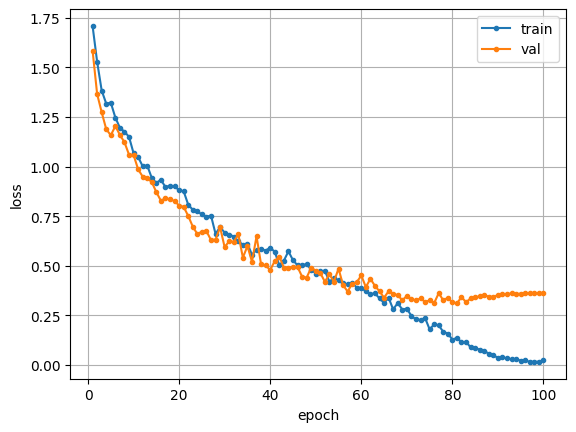

In [30]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['train loss']の長さまでの範囲）
xs = np.arange(1, len(history['train loss']) + 1)
# トレーニングデータの損失をプロット
ax.plot(xs, history['train loss'], '.-', label='train')
# バリデーションデータの損失をプロット
ax.plot(xs, history['val loss'], '.-', label='val')

ax.set_xlabel('epoch') # x軸のラベルを設定
ax.set_ylabel('loss') # y軸のラベルを設定
ax.legend() # 凡例を表示
ax.grid() # グリッドを表示
plt.show() # グラフを表示


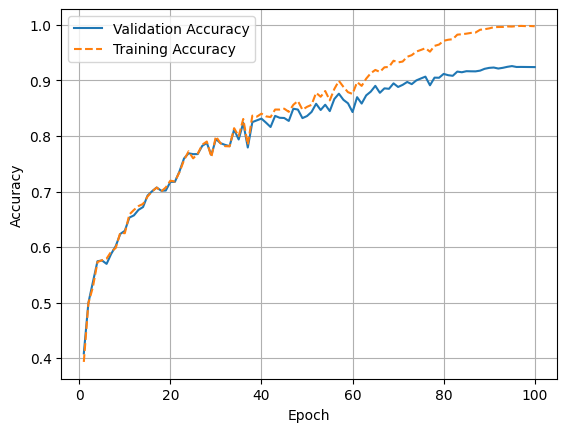

In [31]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['val acc']の長さまでの範囲）
xs = np.arange(1, len(history['val acc']) + 1)
# バリデーションデータの正解率をプロット
ax.plot(xs, history['val acc'], label='Validation Accuracy', linestyle='-')
# トレーニングデータの正解率をプロット
ax.plot(xs, history['train acc'], label='Training Accuracy', linestyle='--')
ax.set_xlabel('Epoch') # x軸のラベルを設定
ax.set_ylabel('Accuracy') # y軸のラベルを設定
ax.grid() # グリッドを表示
ax.legend()  # 凡例を追加
plt.show() # グラフを表示
